In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller

sns.set_theme()
sns.set_palette("pastel")

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data


In [2]:
DATA_PATH = "./data/aligned_data/"

In [3]:
with open("./data/aligned_ticker_1878.json") as jsf:
    new_tickers = json.load(jsf)

In [4]:
prices = pd.read_csv(f"{DATA_PATH}/prices.csv", parse_dates=True, index_col=0)
returns = pd.read_csv(f"{DATA_PATH}/returns.csv", parse_dates=True, index_col=0)
volume = pd.read_csv(f"{DATA_PATH}/volume.csv", parse_dates=True, index_col=0)
ychopmdf = pd.read_csv(f"{DATA_PATH}/ychopmdf.csv", parse_dates=True, index_col=0) / 100
asset_turnover = pd.read_csv(f"{DATA_PATH}/asset_turnover.csv", parse_dates=True, index_col=0)
benchmark_prices = pd.read_csv(f"{DATA_PATH}/benchmark_sp500.csv", parse_dates=True, index_col=0)

sectors_info = pd.read_csv("./data/yf/company_info.csv", index_col=0).loc[:, "sector"]

In [5]:
sectors_info

ticker
A                   Health Care
AACAY    Information Technology
AAON                Industrials
AAP      Consumer Discretionary
AAPL     Information Technology
                  ...          
SDVKY               Industrials
SEB                 Industrials
SEE      Consumer Discretionary
SEIC                 Financials
SEKEY    Information Technology
Name: sector, Length: 1440, dtype: object

In [6]:
benchmark = (1 + benchmark_prices.pct_change()).apply(np.log).iloc[1:]
benchmark.T

Date,2011-04-01,2012-04-01,2013-04-01,2014-04-01,2015-04-01,2016-04-01,2017-04-01,2018-04-01,2019-04-01,2020-04-01,2021-04-01,2022-04-01,2023-04-01
adj_close,0.247869,0.030955,0.164849,0.199141,0.051153,0.01718,0.143781,0.114857,0.078976,0.052488,0.326538,-0.126887,0.085697


# Construct factor matrix


To compose portfolios with lowest Operating Margin and highest Asset Turnover we need a way to select best candidates. To this end, I will constuct a matrix with the difference of normalized Asset Turnover and Operating Margin.


In [7]:
def min_max_scale(df: pd.DataFrame) -> pd.DataFrame:
    """
    This function performs min-max scaling on a pandas DataFrame.
    Min-max scaling transforms the numerical values in each column of the DataFrame to a range between 0 and 1, where the minimum value becomes 0 and the maximum value becomes 1.

    Returns: A pandas DataFrame with the same shape and columns as the input, but with scaled values between 0 and 1.
    """
    df = (df - df.min()) / (df.max() - df.min())
    return df.copy()

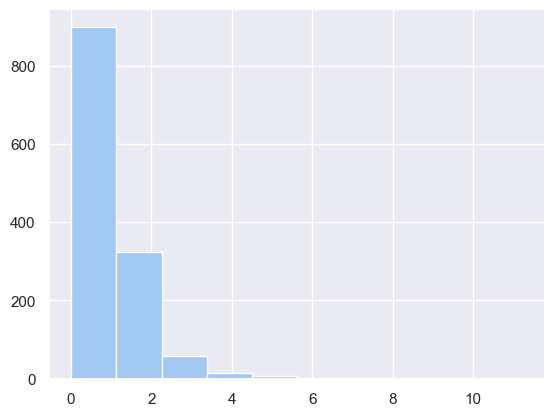

In [8]:
asset_turnover.T["2011-04-01"].hist()
plt.show()

In [55]:
diff_vector = (min_max_scale(asset_turnover.T) - min_max_scale(ychopmdf.T)).T

In [56]:
diff_vector.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13 entries, 2011-04-01 to 2023-04-01
Columns: 1440 entries, A to SEKEY
dtypes: float64(1440)
memory usage: 146.9 KB


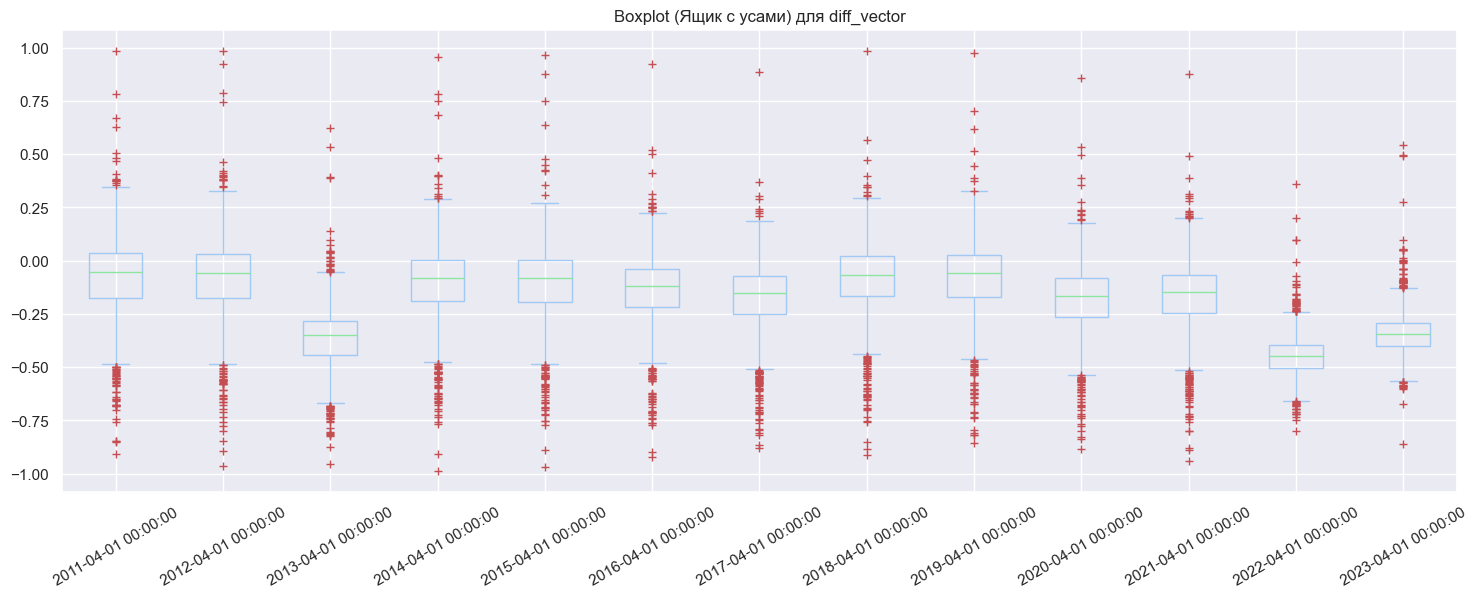

In [58]:
diff_vector.T.plot(kind="box", figsize=(18, 6), rot=30, grid=True, sym="r+")
plt.title("Boxplot (Ящик с усами) для diff_vector")
plt.show()

In [12]:
diff_vector.index

DatetimeIndex(['2011-04-01', '2012-04-01', '2013-04-01', '2014-04-01',
               '2015-04-01', '2016-04-01', '2017-04-01', '2018-04-01',
               '2019-04-01', '2020-04-01', '2021-04-01', '2022-04-01',
               '2023-04-01'],
              dtype='datetime64[ns]', name='date', freq=None)

# Compose portfolio


In [13]:
%autoreload 2
from strategies import PortfolioType, Universe, Portfolio, Strategy  # noqa: F401


## For all companies


In [60]:
universe = Universe(diff_vector, ychopmdf, asset_turnover, returns, volume)
strategy = Strategy()
strategy.construct_portfolios(universe, pd.DateOffset(years=1))

100%|██████████| 12/12 [00:00<00:00, 31.81it/s]


In [61]:
atest_df = pd.concat([port[0].info for port in strategy.portfolios.values()])  # type: ignore

In [62]:
def summarize_strategies(strategy: Strategy) -> pd.DataFrame:
    loht_returns = []
    holt_returns = []

    for loht, holt in strategy.portfolios.values():
        loht_returns.append(loht.mean_return)
        holt_returns.append(holt.mean_return)

    results_df = pd.DataFrame([loht_returns, holt_returns, benchmark.values.flatten()[:-1]])
    results_df.columns = [date.strftime("%Y-%m") for date in diff_vector.index[:-1]]
    results_df = results_df.set_index(
        pd.Index(
            [
                "LOHT",
                "HOLT",
                "S&P 500",
            ],
            name=None,
        )
    )
    return results_df

In [63]:
def plot_summary(strategy: Strategy) -> None:
    old_font_size = plt.rcParams["font.size"]
    plt.rcParams["font.size"] = "12"
    results_df = summarize_strategies(strategy)
    results_df.T.plot(
        kind="bar",
        figsize=(10, 6),
        xlabel=r"$i$ year",
        ylabel="YoY Return",
        width=0.68,
    )

    (results_df.iloc[0] - results_df.iloc[1]).plot(
        kind="bar",
        secondary_y=False,
        color=np.where((results_df.iloc[0] - results_df.iloc[1]) < 0, "red", "deepskyblue"),
        grid=True,
        label="LOHT - HOLT",
        alpha=0.25,
        width=0.68,
    )

    plt.legend(loc="lower left")
    plt.xticks(rotation=45)
    plt.subplots_adjust(bottom=0.15)
    plt.show()
    plt.rcParams["font.size"] = old_font_size

In [64]:
df = summarize_strategies(strategy).T
df

,LOHT,HOLT,S&P 500
2011-04,0.099557,-0.158522,0.247869
2012-04,0.380308,-0.064528,0.030955
2013-04,0.183221,0.127379,0.164849
2014-04,-0.147656,-0.331456,0.199141
2015-04,-0.224350,0.026348,0.051153
2016-04,0.130716,0.106864,0.017180
2017-04,0.117688,0.260619,0.143781
2018-04,0.092883,0.179605,0.114857
2019-04,-0.385748,-0.585292,0.078976
2020-04,0.316810,0.414101,0.052488


In [19]:
%autoreload 2
from stats_tools import *

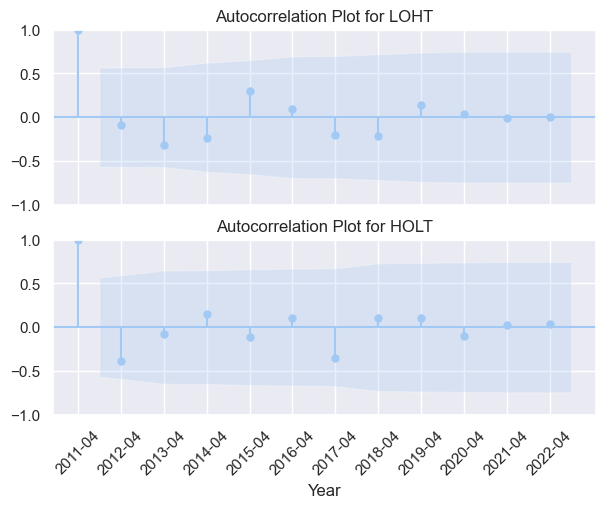

In [20]:
plot_acf_cmp(df)

In [65]:
ljungbox_test(df), adf_test(df)

((0.3120269697041822, 0.1256629277733983),
 (9.113324634551366e-05, 0.001070002282081196))

In [66]:
print(wilcoxon_rs_test(df))
print(twosample_ttest(df))

RanksumsResult(statistic=0.8660254037844386, pvalue=0.3864762307712327)
(1.0104511732110286, 0.3240399663995581)


In [68]:
ALPHA = 0.10
is_not_autocorr = all(el > ALPHA for el in ljungbox_test(df))
is_statry = all(el < ALPHA for el in adf_test(df))
is_normal = all(el > ALPHA for el in shapiro_test(df))
print(
        f"not autocorr.: {is_not_autocorr},  \t stationary: {is_statry}, \t {is_normal=}"
    )

not autocorr.: True,  	 stationary: True, 	 is_normal=True


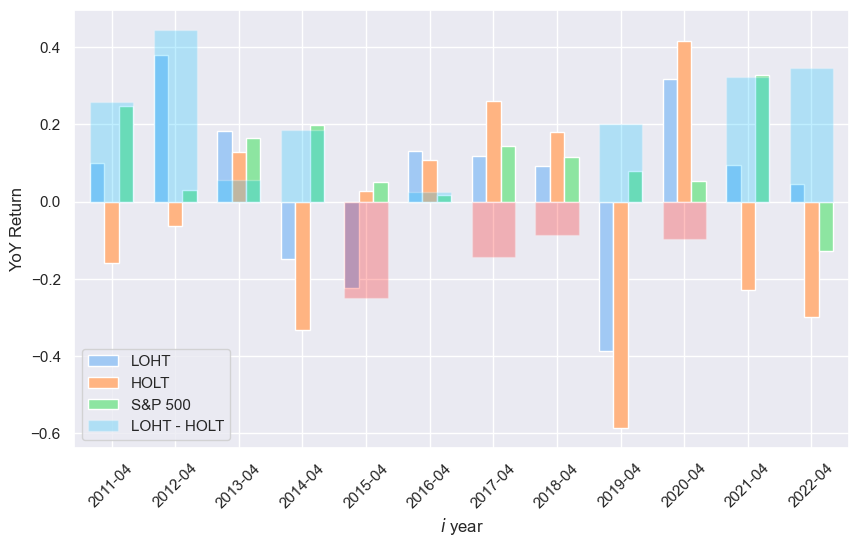

In [24]:
plot_summary(strategy)

## Sector-wise


In [80]:
sectored_strategies: dict[str, Strategy] = dict()
for sect in sectors_info.unique():
    sector_companies = sectors_info[sectors_info == sect].index.to_list()
    universe = Universe(diff_vector, ychopmdf, asset_turnover, returns, volume)
    universe.symbols = sector_companies
    universe.prune_companies()
    print(f"{sect:<30} {len(universe.symbols)}")
    strategy = Strategy()
    strategy.construct_portfolios(universe, pd.DateOffset(years=1))
    sectored_strategies[sect] = strategy

Health Care                    120
Information Technology         180
Industrials                    294
Consumer Discretionary         215
Real Estate                    84
Energy                         110
Consumer Staples               117
Materials                      136
Utilities                      75
Financials                     42
Communication Services         67


In [26]:
print(summarize_strategies(sectored_strategies["Communication Services"]).T.iloc[:, :2])

             LOHT      HOLT
2011-04 -0.386487 -0.094541
2012-04  0.532156  0.117188
2013-04  0.288779  0.295664
2014-04  0.365941  0.186712
2015-04 -0.093743 -0.074141
2016-04  0.053272  0.142314
2017-04 -0.007514 -0.049747
2018-04 -0.087833 -0.006116
2019-04  0.041072 -0.393172
2020-04  0.764643  0.445447
2021-04  0.404244 -0.296112
2022-04  0.286365 -0.242187


In [27]:
shapiro_test(df)

(0.9954490661621094, 0.3318859934806824)

In [28]:
shapiro_test(summarize_strategies(sectored_strategies["Real Estate"]).T)

(0.020383382216095924, 0.12951035797595978)

In [78]:
%autoreload 2
from stats_tools import *

In [52]:
ALPHA = 0.15
for sect in sectored_strategies:
    df = summarize_strategies(sectored_strategies[sect]).T
    is_not_autocorr = all(el > ALPHA for el in ljungbox_test(df))
    is_statry = all(el < ALPHA for el in adf_test(df))
    is_normal = all(el > ALPHA for el in shapiro_test(df))
    print(bootstrap_test(df, alpha=ALPHA))
    print(
        f"{sect:<25} not autocorr.: {is_not_autocorr},  \t stationary: {is_statry}, \t {is_normal=}"
    )
    # print(wilcoxon_rs_test(df))
    print(round(wilcoxon_rs_test(df)[1], 2), twosample_ttest(df))
    print()
    # adf_test(df)

ConfidenceInterval(low=-0.14204264057157626, high=0.1229072638300551)
Health Care               not autocorr.: False,  	 stationary: False, 	 is_normal=False
0.95 (-0.1061874828372831, 0.9164954341600406)

ConfidenceInterval(low=-0.08770468349514829, high=0.1176154573194732)
Information Technology    not autocorr.: False,  	 stationary: False, 	 is_normal=True
0.95 (0.1844371801893217, 0.8553910245036609)

ConfidenceInterval(low=-0.193643254672268, high=0.19724071287098144)
Industrials               not autocorr.: False,  	 stationary: True, 	 is_normal=False
0.73 (0.056732295333997, 0.9553108439237534)

ConfidenceInterval(low=-0.11417331665224192, high=0.13227957338531343)
Consumer Discretionary    not autocorr.: False,  	 stationary: True, 	 is_normal=True
0.69 (0.13111180347674933, 0.8969966216908607)

ConfidenceInterval(low=-0.012844851119037605, high=0.20267132576207603)
Real Estate               not autocorr.: False,  	 stationary: False, 	 is_normal=False
0.49 (1.148975730959979

In [75]:
summarize_strategies(sectored_strategies["Communication Services"]).T.to_clipboard()

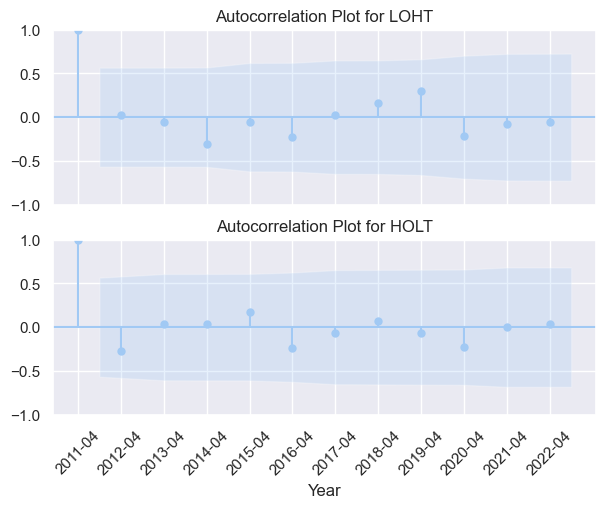

In [70]:
plot_acf_cmp(summarize_strategies(sectored_strategies["Communication Services"]).T)

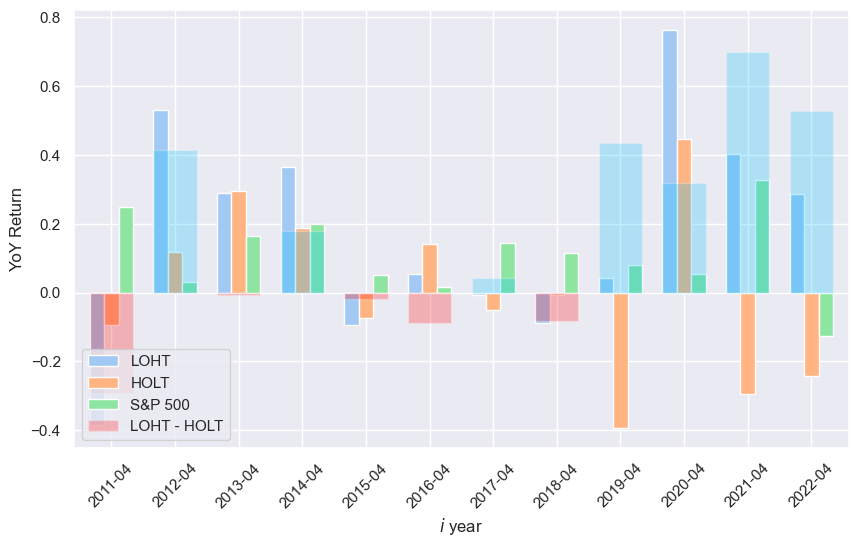

In [71]:
plot_summary(sectored_strategies["Communication Services"])